# TaskLoader

[The `TaskLoader`](../reference/data/loader.rst) generates `Task` objects for training, testing, and inference with DeepSensor models.
The `TaskLoader` can generate `Task`s for different kinds of predictions, such as: spatial interpolation, forecasting, downscaling, or some combination of these.
It achieves this by temporally slicing spatiotemporal data and then providing a suite of spatial sampling methods for generating context and target sets from the temporal slices.

Mastering DeepSensor requires a good understanding of all the ways you can initialise and call a `TaskLoader` for a wide range of data fusion applications.
The `TaskLoader` is best understood through examples, which we will see in this page.
Let's import the `TaskLoader` class and get started.

In [1]:
import logging

logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.data import DataProcessor
from deepsensor.data.sources import get_ghcnd_station_data, get_era5_reanalysis_data, get_earthenv_auxiliary_data, get_gldas_land_mask

import matplotlib.pyplot as plt

# Using the same settings allows use to use pre-downloaded cached data
data_range = ("2016-06-25", "2016-06-30")
extent = "europe"
station_var_IDs = ["TAVG", "PRCP"]
era5_var_IDs = ["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind"]
auxiliary_var_IDs = ["elevation", "tpi"]
cache_dir = "../../.datacache"

station_raw_df = get_ghcnd_station_data(station_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir)
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir)
auxiliary_raw_ds = get_earthenv_auxiliary_data(auxiliary_var_IDs, extent, "10KM", cache=True, cache_dir=cache_dir)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir)

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds)
aux_ds, land_mask_ds = data_processor([auxiliary_raw_ds, land_mask_raw_ds], method="min_max")
station_df = data_processor(station_raw_df)

In [2]:
from deepsensor.data import TaskLoader

## Initialising a TaskLoader

A `TaskLoader` is initialised with list of `context` and `target` variables.
These variables can either be `xarray` or `pandas` objects, and are assumed to have been standardised by a `DataProcessor`.

We will use the normalised station and reanalysis data from the previous [](data_processor.ipynb) page.

In [3]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds],
    target=station_df,
    aux_at_targets=aux_ds,
)
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind'), ('GLDAS_mask',))
Target variable IDs: (('PRCP', 'TAVG'),)
Auxiliary-at-target variable IDs: ('elevation', 'tpi')


## Calling a TaskLoader

The `TaskLoader` is called with a timestamp and single entries or lists of entries for the `context_sampling` and `target_sampling` arguments.
These arguments can either be single entries (applying the same sampling strategy to each context/target set)
or a list of entries equal to the number of context/target sets (applying different sampling strategies to
each context/target set).

For an up-to-date list of the available sampling strategies and what they do, see the
[`TaskLoader.task_generation` documentation](https://tom-andersson.github.io/deepsensor/reference/data/loader.html#deepsensor.data.loader.TaskLoader.task_generation).

In [4]:
task = task_loader("2016-06-25", context_sampling="all", target_sampling="all")
print(task)

time: 2016-06-25 00:00:00
ops: []
X_c: [((1, 141), (1, 221)), ((1, 140), (1, 220))]
Y_c: [(3, 141, 221), (1, 140, 220)]
X_t: [(2, 519)]
Y_t: [(2, 519)]
Y_t_aux: (2, 519)


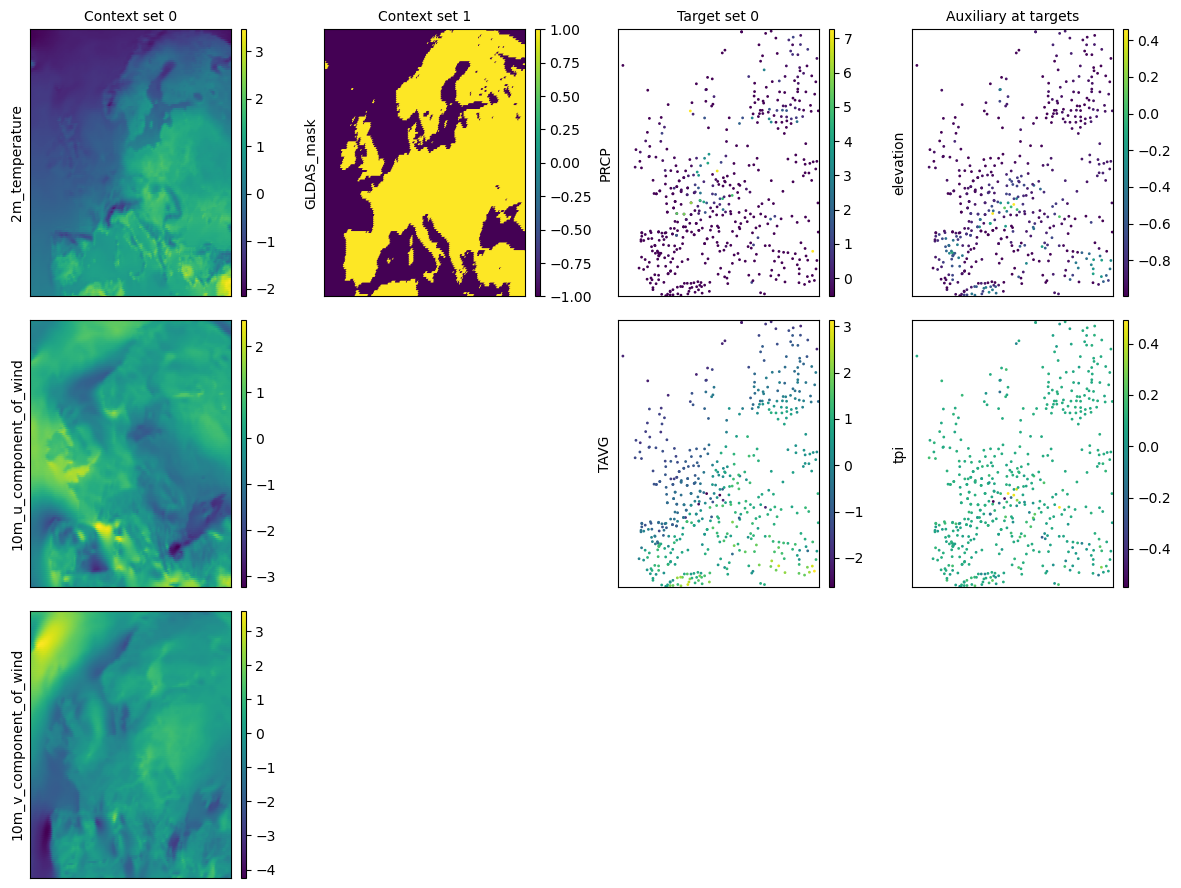

In [5]:
fig = deepsensor.plot.task(task, task_loader)
plt.show()

## TaskLoader tour

Now that we've got the basics of the `TaskLoader` init and call signatures,
let's see some concrete examples of to generate `Task` objects for
spatial interpolation, forecasting, downscaling, and gap-filling.

### Spatial interpolation

Spatial interpolation tasks can be generated either from:
- gridded `xarray` data, by randomly sampling points from the grid, or
- pointwise `pandas` data, by randomly splitting the data into context and target sets.

#### Interpolating gridded `xarray` data

##### Randomly sampling a `float` fraction of points

In [6]:
task_loader = TaskLoader(context=era5_ds["2m_temperature"], target=era5_ds["2m_temperature"])
task = task_loader("2016-06-28", context_sampling=0.03, target_sampling="all")
print(task)

time: 2016-06-28 00:00:00
ops: []
X_c: [(2, 934)]
Y_c: [(1, 934)]
X_t: [((1, 141), (1, 221))]
Y_t: [(1, 141, 221)]


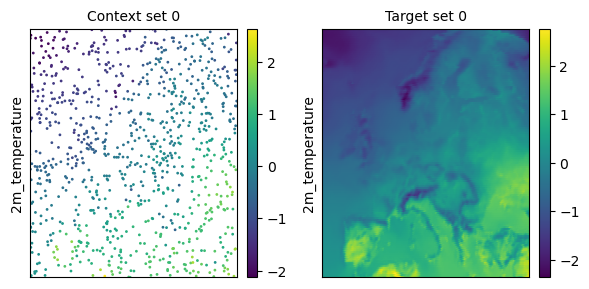

In [7]:
deepsensor.plot.task(task, task_loader)
plt.show()

##### Randomly sampling a `int` number of points

In [8]:
task = task_loader("2016-06-25", context_sampling=100, target_sampling=1000)
print(task)

time: 2016-06-25 00:00:00
ops: []
X_c: [(2, 100)]
Y_c: [(1, 100)]
X_t: [(2, 1000)]
Y_t: [(1, 1000)]


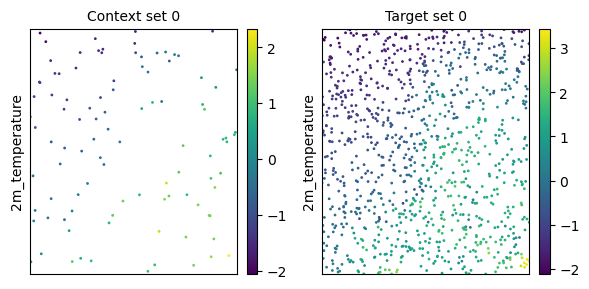

In [9]:
deepsensor.plot.task(task, task_loader)
plt.show()

#### Interpolating pointwise `pandas` data

In [10]:
task_loader = TaskLoader(context=station_df["TAVG"], target=station_df["TAVG"], links=[(0, 0)])

In [11]:
task = task_loader("2016-06-25", context_sampling="split", target_sampling="split", split_frac=0.1)
print(task)

time: 2016-06-25 00:00:00
ops: []
X_c: [(2, 72)]
Y_c: [(1, 72)]
X_t: [(2, 592)]
Y_t: [(1, 592)]


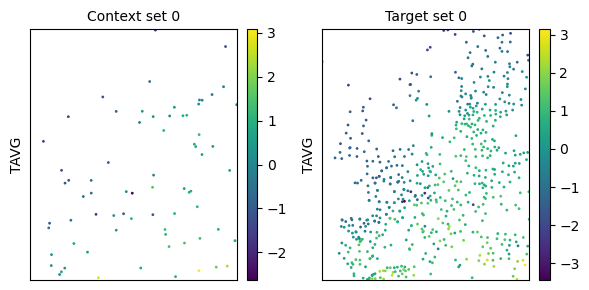

In [12]:
deepsensor.plot.task(task, task_loader)
plt.show()

### Forecasting

Using the `context_delta_t` and/or `target_delta_t` arguments, we can generate `Task`s for forecasting.
The values of `context_delta_t` and `target_delta_t` are time differences relative to the time slice passed to the `TaskLoader` (which may be considered as an 'initialisation time').
The units of these time detlas are determined by the `time_freq` argument, which defaults to `"D"` (days).

In [13]:
task_loader = TaskLoader(
    context=[era5_ds["2m_temperature"],] * 3,
    context_delta_t=[-1, -2, 0],
    target=era5_ds["2m_temperature"],
    target_delta_t=1,
    time_freq="D",  # daily frequency (the default)
)
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('2m_temperature',), ('2m_temperature',))
Target variable IDs: (('2m_temperature',),)


In [14]:
task = task_loader("2016-06-27", context_sampling="all", target_sampling="all")
print(task)

time: 2016-06-27 00:00:00
ops: []
X_c: [((1, 141), (1, 221)), ((1, 141), (1, 221)), ((1, 141), (1, 221))]
Y_c: [(1, 141, 221), (1, 141, 221), (1, 141, 221)]
X_t: [((1, 141), (1, 221))]
Y_t: [(1, 141, 221)]


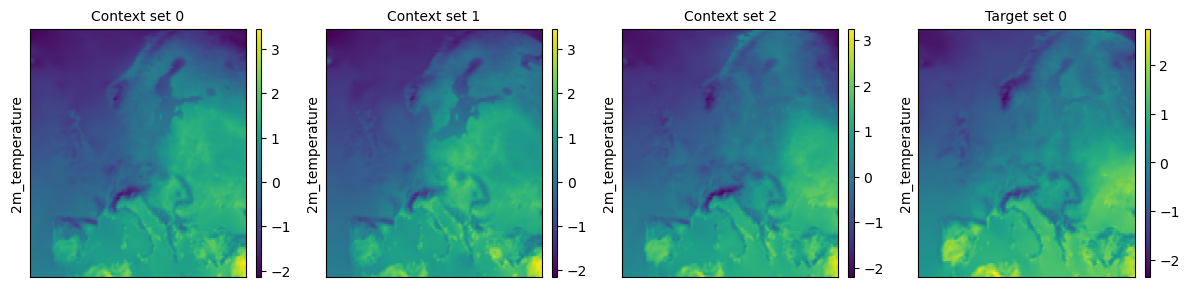

In [15]:
deepsensor.plot.task(task, task_loader)
plt.show()

### Downscaling

In statistical downscaling, the goal is often to learn a mapping from a coarse gridded data set (e.g. reanalysis data) to localised observations (e.g. weather station data).
A downscaling `TaskLoader` can be instantiated by passing the coarse gridded variable in the `context` list and station observations in the `target` list.

Optionally, we can also pass a high-resolution auxiliary `xarray` variable (e.g. local topgraphic information) via the `aux_at_targets` argument.
When calling the `TaskLoader`, the `aux_at_targets` variable will be interpolated at the target locations and added to the `Task` as the `"Y_t_aux"` entry.
The `"Y_t_aux"` data can be modelled differently from the context data, for example, by using a pointwise MLP rather than a convolutional neural network.

```{note}
The `TaskLoader` also permits an `aux_at_contexts` argument for passing high-resolution auxiliary variables at off-grid context locations.
For brevity, we will not demonstrate this here.
```

Hypothetically, with the right auxiliary information and enough data, a model can distinguish between an observation from the top of a mountain vs a valley vs a city vs a field.

In [16]:
task_loader = TaskLoader(
    context=[era5_ds["2m_temperature"], land_mask_ds],
    target=station_df["TAVG"],
    aux_at_targets=aux_ds,
)
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',))
Target variable IDs: (('TAVG',),)
Auxiliary-at-target variable IDs: ('elevation', 'tpi')


In [17]:
task = task_loader("2016-06-25", context_sampling="all", target_sampling="all")
print(task)

time: 2016-06-25 00:00:00
ops: []
X_c: [((1, 141), (1, 221)), ((1, 140), (1, 220))]
Y_c: [(1, 141, 221), (1, 140, 220)]
X_t: [(2, 664)]
Y_t: [(1, 664)]
Y_t_aux: (2, 664)


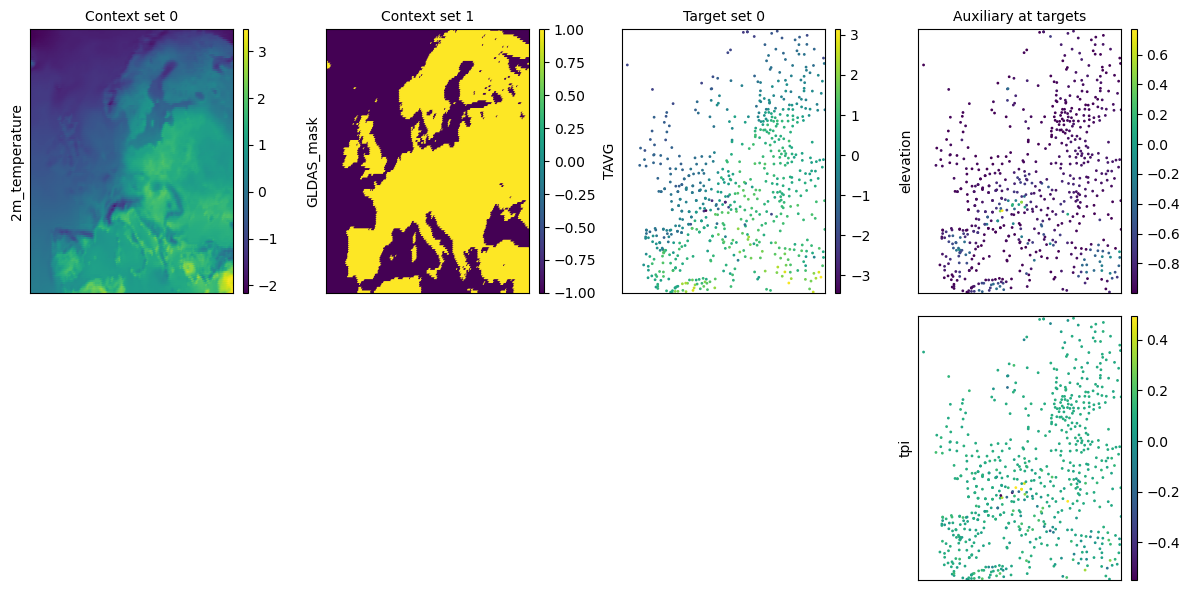

In [18]:
deepsensor.plot.task(task, task_loader)
plt.show()

### Gap-filling

The `TaskLoader` can be used to generate training `Task`s for filling missing data gaps in an `xarray` object.

Let's generate some fake missing data in the normalised `era5_ds` object by setting all normalised temperature values
below -0.75 to NaN.
In practice, these may be missing due to cloud coverage, satellite orbit gaps, sensor issues, or other reasons.

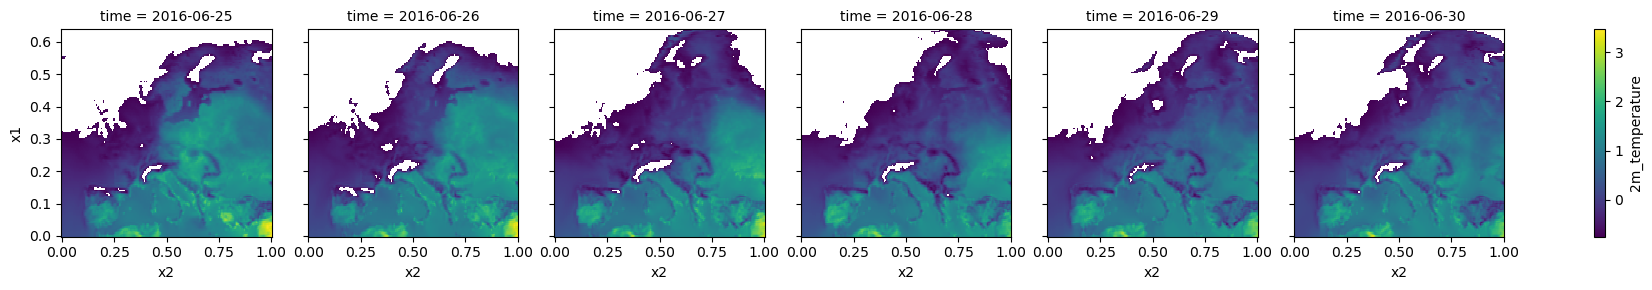

In [19]:
era5_gappy_ds = era5_ds["2m_temperature"].where(era5_ds["2m_temperature"] > -0.75)
fig = era5_gappy_ds.plot(col="time", col_wrap=6, center=False)
plt.show()

If we pass the `"gapfill"` argument to the `context_sampling` and `target_sampling` arguments, the `TaskLoader` does the following:
- randomly samples a missing data mask from another time slice,
- adds this new mask to the context set (increasing the amount of missing data in the context set),
- the context points which were just removed by the new mask become the target set.

This may produce NaNs in the target set due to overlap between the original mask and new mask.
To remove these NaNs, use the `Task.remove_context_nans` and `Task.remove_target_nans` methods.

In [20]:
task_loader = TaskLoader(context=era5_gappy_ds, target=era5_gappy_ds, links=[(0, 0)])
task = task_loader("2016-06-25", context_sampling="gapfill", target_sampling="gapfill")
print(task.remove_context_nans().remove_target_nans())

time: 2016-06-25 00:00:00
ops: ['context_nans_removed', 'target_nans_removed']
X_c: [(2, 22491)]
Y_c: [(1, 22491)]
X_t: [(2, 867)]
Y_t: [(1, 867)]


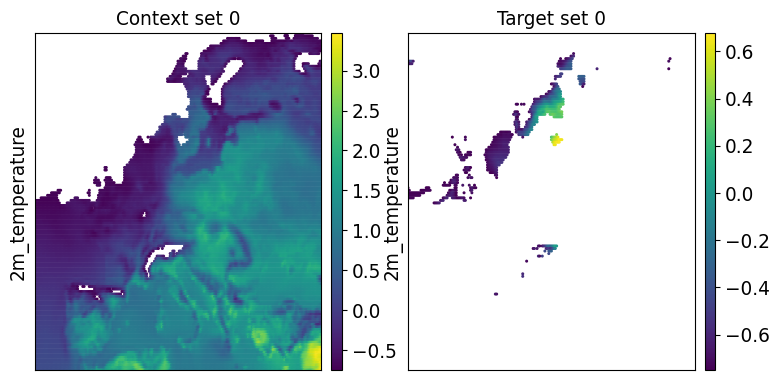

In [21]:
deepsensor.plot.task(task, task_loader, figsize=4)
plt.show()

The spatial characteristics of the missing data in the context set appear realistic and
will be similar to what the model will see when attempting to fill real missing data gaps.

Once a model is trained with `Task`s generated with the `"gapfill"` strategy, the model can
be used to fill real missing data by passing `"all"` for `context_sampling`.

```{caution} 
Recall that we generated missing data by masking any normalised temperature values below -0.75
to NaN.
This means that the true missing data is *not representative* of the observed
data; the distribution of observed data is very different to the distribution of missing data.
A model trained with the `TaskLoader` `"gapfill"` strategy will never see values below -0.75
and therefore its predictions will be heavily biased.

This is an extreme example, but the same effect can occur in real data sets.
For example, if missing data comes from
clouds and the target variable is temperature, a model trained with the `"gapfill"` strategy
will not learn the effect of clouds on temperature.
```

### Combinations of data fusion tasks

Real applications may involve a combination of the above data fusion tasks.
The flexibility of the `TaskLoader` makes it easy to generate `Task`s for
diverse data fusion problems.
Here's a concrete example combining forecasting with downscaling, using the past
two days of ERA5 data to forecast the next day of station observations,
leveraging high-resolution auxiliary data.

In [29]:
task_loader = TaskLoader(
    context=[era5_ds["2m_temperature"], era5_ds["2m_temperature"], land_mask_ds],
    context_delta_t=[-1, -2, 0],
    target=station_df["TAVG"],
    target_delta_t=1,
    aux_at_targets=aux_ds,
)
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('2m_temperature',), ('GLDAS_mask',))
Target variable IDs: (('TAVG',),)
Auxiliary-at-target variable IDs: ('elevation', 'tpi')


In [30]:
task = task_loader("2016-06-28", context_sampling="all", target_sampling="all")
print(task)

time: 2016-06-28 00:00:00
ops: []
X_c: [((1, 141), (1, 221)), ((1, 141), (1, 221)), ((1, 140), (1, 220))]
Y_c: [(1, 141, 221), (1, 141, 221), (1, 140, 220)]
X_t: [(2, 667)]
Y_t: [(1, 667)]
Y_t_aux: (2, 667)


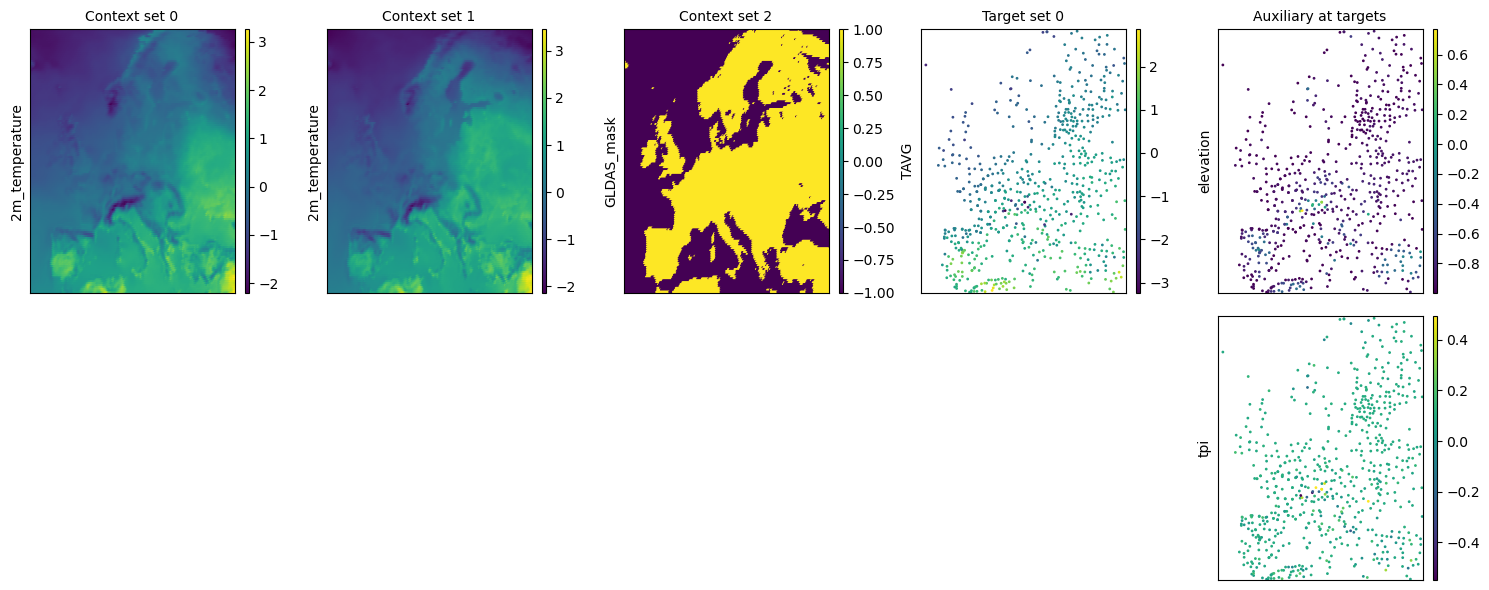

In [31]:
deepsensor.plot.task(task, task_loader)
plt.show()

## Controlling randomness in the TaskLoader

There are two additional arguments in the `TaskLoader` call method for controlling randomness:
- `datewise_deterministic`: If `True`, the same random seed will be used for a particlar date. Useful for,
say, generating a reproducible validation set which is the same between Python sessions.
- `seed_override`: If not `None`, this seed will be used instead of the default seed.


## Saving and loading a TaskLoader

You can save the `TaskLoader` object to a file using the `.save` method.

```{note}
Currently, saving a `TaskLoader` is only supported it it has been initialised with `str` paths to NetCDF or CSV files,
allowing the `TaskLoader` to be represented with a configuration file which can then be saved and loaded.
It would be useful to be able to save `TaskLoader`s initialised with `xarray` or `pandas` objects by saving
the objects to NetCDF or CSV files under the hood.
There is an [issue](https://github.com/tom-andersson/deepsensor/issues/84) open about this.
```

In [32]:
data_fpath = "tmp.nc"
era5_ds.to_netcdf(data_fpath)

In [33]:
task_loader = TaskLoader(context=data_fpath, target=data_fpath)
print(task_loader)

TaskLoader(1 context sets, 1 target sets)
Context variable IDs: (('2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind'),)
Target variable IDs: (('2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind'),)


In [34]:
task_loader.save("tmp/")

In [35]:
task_loader_loaded = TaskLoader("tmp/")
print(task_loader_loaded)

TaskLoader(1 context sets, 1 target sets)
Context variable IDs: (('2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind'),)
Target variable IDs: (('2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind'),)


In [36]:
import os
import shutil
os.remove(data_fpath)
shutil.rmtree("tmp/")